0
1
2
3
4
5
6
7
8
9
[1]


<Figure size 5000x700 with 0 Axes>

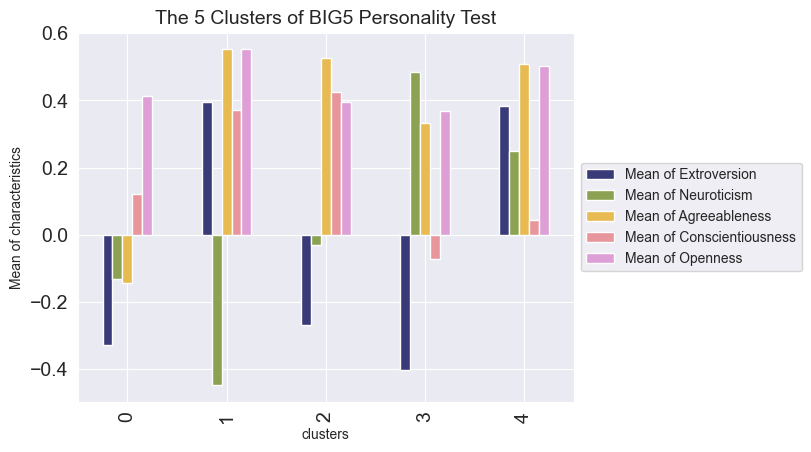

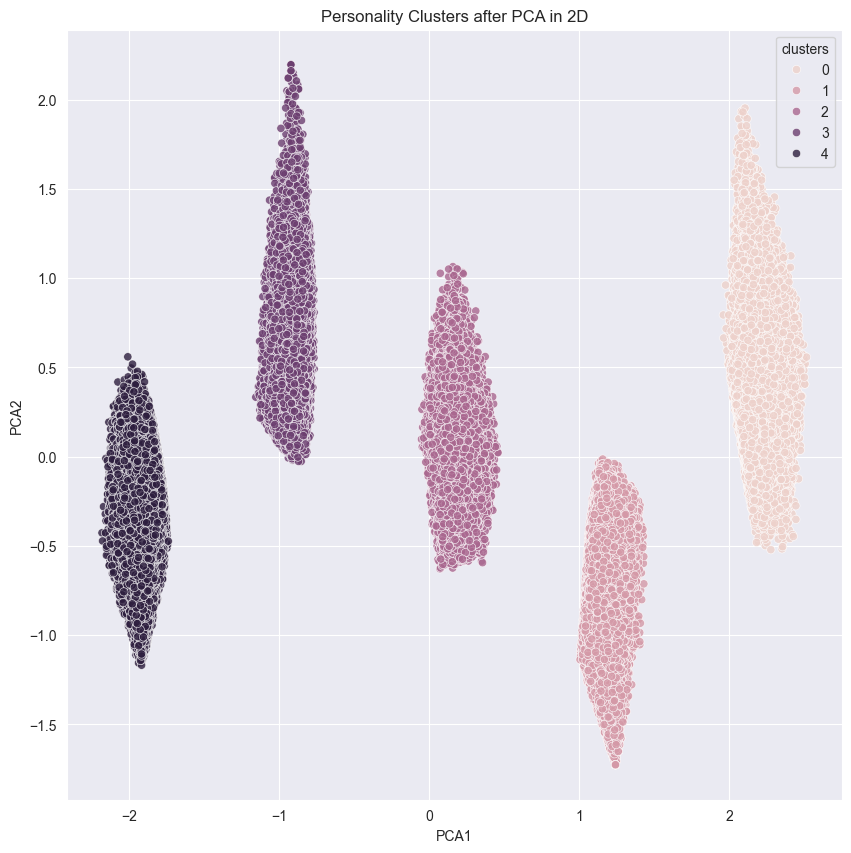

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from flask import Flask, jsonify, request
from kmeans import KMeansClustering
from kmeansT import KMeansClusteringT
from sklearn.decomposition import PCA
import seaborn as sns



kmeans = KMeansClusteringT(k=5)
filename = "bigFiveDataset/data-final.csv"
read_data = pd.read_csv(filename, delimiter='\t')
read_data = read_data.iloc[:, :50]
read_data = read_data.replace(0, np.nan)
read_data.dropna(axis=0, inplace=True)

ext_questions = {'EXT1': 'I am the life of the party.',
                     'EXT2': 'I don\'t talk a lot.',
                     'EXT3': 'I feel comfortable around people.',
                     'EXT4': 'I keep in the background.',
                     'EXT5': 'I start conversations.',
                     'EXT6': 'I have little to say.',
                     'EXT7': 'I talk to a lot of different people at parties.',
                     'EXT8': 'I don\'t like to draw attention to myself.',
                     'EXT9': 'I don\'t mind being the center of attention.',
                     'EXT10': 'I am quiet around strangers.'}

neu_questions = {'EST1': 'I get stressed out easily.',  # nervous
                     'EST2': 'I am relaxed most of the time.',  # confident
                     'EST3': 'I worry about things.',  # nervous
                     'EST4': 'I seldom feel blue.',  # confident
                     'EST5': 'I am easily disturbed.',  # nervous
                     'EST6': 'I get upset easily.',  # nervous
                     'EST7': 'I change my mood a lot.',  # nervous
                     'EST8': 'I have frequent mood swings.',  # nervous
                     'EST9': 'I get irritated easily',  # nervous
                     'EST10': 'I often feel blue.'}  # nervous

    # measure of one's trusting and helpful nature
agr_questions = {'AGR1': 'I feel little concern for others.',  # detached
                     'AGR2': 'I am interested in people.',  # friendly
                     'AGR3': 'I insult people.',  # detached
                     'AGR4': 'I sympathize with others feelings.',  # friendly
                     'AGR5': 'I am not interested in other people problems.',  # detached
                     'AGR6': 'I have a soft heart',  # friendly
                     'AGR7': 'I am not really interested in others.',  # detached
                     'AGR8': 'I take time out for others',  # friendly
                     'AGR9': 'I feel others emotions',  # friendly
                     'AGR10': 'I make people feel at ease.'}  # friendly

    # tendency to be organized and dependable
con_questions = {'CSN1': 'I am always prepared.',  # organized
                     'CSN2': 'I leave my belongings around.',  # careless
                     'CSN3': 'I pay attention to details',  # organized
                     'CSN4': 'I make a mess of things.',  # careless
                     'CSN5': 'I get chores done right away.',  # organized
                     'CSN6': 'I often forget to put things back in their proper place.',  # careless
                     'CSN7': 'I like order.',  # organized
                     'CSN8': 'I shirk my duties.',  # careless
                     'CSN9': 'I follow a schedule.',  # organized
                     'CSN10': 'I am exacting in my work.'}  # organized

    # degree of intellectual curiosity, creativity and a preference for novelty
opn_questions = {'OPN1': 'I have a rich vocabulary.',  # inventive
                     'OPN2': 'I have difficulty understanding abstract ideas.',  # cautious/consistent
                     'OPN3': 'I have a vivid imagination.',  # inventive
                     'OPN4': 'I am not interested in abstract ideas.',  # cautious/consistent
                     'OPN5': 'I have excellent ideas',  # inventive
                     'OPN6': 'I do not have a good imagination.',  # cautious/consistent
                     'OPN7': 'I am quick to understand things.',  # inventive
                     'OPN8': 'I use difficult words.',  # inventive
                     'OPN9': 'I spend time reflecting on things.',  # inventive
                     'OPN10': 'I am full of ideas.'}  # inventive

def invert(column):
    read_data[column] = read_data[column].replace(5, -5)
    read_data[column] = read_data[column].replace(4, -4)
    read_data[column] = read_data[column].replace(3, -3)
    read_data[column] = read_data[column].replace(2, -2)
    read_data[column] = read_data[column].replace(1, -1)

scaler = MinMaxScaler(feature_range=(-1, 1))
changed_qs = ['EXT2', 'EXT4', 'EXT6', 'EXT8', 'EXT10',
                  'EST2', 'EST4',
                  'AGR1', 'AGR3', 'AGR5', 'AGR7',
                  'CSN2', 'CSN4', 'CSN6', 'CSN8',
                  'OPN2', 'OPN4', 'OPN6']

for col in read_data:
    if col in changed_qs:
        invert(col)
        
def summation(ocean_dict, label):
    read_data[label] = 0
    for x in ocean_dict.keys():
        read_data[label] += read_data[x]
    read_data[label] = scaler.fit_transform(read_data[[label]])
    
summation(ext_questions,'extroversion_score')
summation(neu_questions,'neuroticism_score')
summation(agr_questions,'agreeableness_score')
summation(con_questions,'conscientiousness_score')
summation(opn_questions,'openness_score')


data_for_training = read_data[['extroversion_score', 'neuroticism_score', 'agreeableness_score',  'conscientiousness_score', 'openness_score']].copy()

k_fit = kmeans.fit(data_for_training.to_numpy())

data_for_training['clusters'] = k_fit
K_predict = kmeans.predict(np.array([[1, -0.7, -0.2, 0.70, -0.8]]))
print(K_predict)

data_for_training = pd.DataFrame(data_for_training)
desc = data_for_training.groupby('clusters')[['extroversion_score', 'neuroticism_score', 'agreeableness_score',
                                                  'conscientiousness_score', 'openness_score']].describe()
summary = pd.concat(
        objs=(i.set_index('clusters') for i in (
            desc['extroversion_score'][['count', 'mean']].reset_index(),
            desc['neuroticism_score'][['mean']].reset_index(),
            desc['agreeableness_score'][['mean']].reset_index(),
            desc['conscientiousness_score'][['mean']].reset_index(),
            desc['openness_score'][['mean']].reset_index())),
        axis=1,
        join='inner').reset_index()
summary.columns = ['clusters', 'cluster_count', 'extroversion_mean', 'neuroticism_mean', 'agreeableness_mean',
                       'conscientiousness_mean', 'openness_mean']

plt.figure(figsize=(50, 7))
summary.plot(x='clusters',
                 y=['extroversion_mean', 'neuroticism_mean', 'agreeableness_mean', 'conscientiousness_mean',
                    'openness_mean'],
                 kind='bar',
                 ylabel='Mean of characteristics',
                 fontsize=14, cmap="tab20b").legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                                    labels=['Mean of Extroversion',
                                                            'Mean of Neuroticism',
                                                            'Mean of Agreeableness',
                                                            'Mean of Conscientiousness',
                                                            'Mean of Openness'])
plt.title('The 5 Clusters of BIG5 Personality Test', fontsize=14)
plt.show()


pca_2 = PCA(n_components=2)
pca_fit = pca_2.fit_transform(data_for_training)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['clusters'] = k_fit

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='clusters', alpha=0.8)
plt.title('Personality Clusters after PCA in 2D')
plt.show()






   

In [22]:
summary.head()

,clusters,cluster_count,extroversion_mean,neuroticism_mean,agreeableness_mean,conscientiousness_mean,openness_mean
0,0,133274.0,-0.329088,-0.131573,-0.144930,0.122588,0.414465
1,1,181150.0,0.396410,-0.447612,0.553131,0.371274,0.552408
2,2,189166.0,-0.268237,-0.031068,0.525321,0.425468,0.396244
3,3,174329.0,-0.401712,0.483879,0.332552,-0.073203,0.368309
4,4,196515.0,0.382226,0.250722,0.508879,0.044448,0.501554


In [7]:

scaler.fit_transform(read_data[['neuroticism_score']])

array([[-0.3 ],
       [-0.25],
       [-0.2 ],
       ...,
       [-0.05],
       [ 0.25],
       [-0.05]])

In [8]:
data_for_training.head()

,extroversion_score,neuroticism_score,agreeableness_score,conscientiousness_score,openness_score,clusters
0,16.0,12.0,15.0,8.0,27.0,0
1,-10.0,13.0,20.0,13.0,17.0,2
2,-5.0,14.0,18.0,10.0,23.0,4
3,-4.0,17.0,14.0,1.0,21.0,1
4,-1.0,7.0,22.0,24.0,30.0,0


In [13]:
def ceva():
    read_data['lala'] = 0
ceva()
read_data['lala']

0          0
1          0
2          0
3          0
4          0
          ..
1015336    0
1015337    0
1015338    0
1015339    0
1015340    0
Name: lala, Length: 874434, dtype: int64

In [20]:
def summation(ocean_dict, label):
    read_data[label] = 0
    for x in ocean_dict.keys():
        read_data[label] += read_data[x]
    read_data[label] = scaler.fit_transform(read_data[[label]])
    
summation(ext_questions,'extroversion_score')
summation(neu_questions,'neuroticism_score')
summation(agr_questions,'agreeableness_score')
summation(con_questions,'conscientiousness_score')
summation(opn_questions,'openness_score')
read_data.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7,OPN8,OPN9,OPN10,extroversion_score,neuroticism_score,agreeableness_score,conscientiousness_score,openness_score,lala
0,4.0,-1.0,5.0,-2.0,5.0,-1.0,5.0,-2.0,4.0,-1.0,...,5.0,3.0,4.0,5.0,0.80,-0.30,0.45,0.10,0.75,0
1,3.0,-5.0,3.0,-4.0,3.0,-3.0,2.0,-5.0,1.0,-5.0,...,4.0,2.0,5.0,3.0,-0.50,-0.25,0.70,0.35,0.25,0
2,2.0,-3.0,4.0,-4.0,3.0,-2.0,1.0,-3.0,2.0,-5.0,...,5.0,3.0,4.0,4.0,-0.25,-0.20,0.60,0.20,0.55,0
3,2.0,-2.0,2.0,-3.0,4.0,-2.0,2.0,-4.0,1.0,-4.0,...,4.0,4.0,3.0,3.0,-0.20,-0.05,0.40,-0.25,0.45,0
4,3.0,-3.0,3.0,-3.0,5.0,-3.0,3.0,-5.0,3.0,-4.0,...,5.0,3.0,5.0,5.0,-0.05,-0.55,0.80,0.90,0.90,0


In [23]:
df_pca

,PCA1,PCA2,clusters
0,1.108935,-0.803710,1
1,0.196767,0.116616,2
2,0.171552,-0.029250,2
3,-0.848211,0.174166,3
4,1.231475,-0.612140,1
...,...,...,...
874429,-1.861677,-0.077346,4
874430,-1.970015,0.161536,4
874431,-1.868843,-0.290991,4
874432,0.135747,0.335819,2
